# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle MARTY, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

from functions.modelling import *

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [2]:
alt_path = 'data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

from functions.importing import read_whole_pandas_df

print(f"✅ read_whole_pandas_df function imported; alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function imported; alternative_path set as:
data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Velo'v data import

In [3]:
# Data folder's path
BASE_PATH = r"data/"
# Velo'v data's path
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
# Velo'v stations locations file's path
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
# Lyon's contours dataset's path
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
# Coordinates of the center of Lyon
LYON_CENTER = (45.764043, 4.835659)
# Importing the data into a dataframe
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"],
                               alternative_dataset=True)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
df_lyon.head()

Reading file data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
✅ All datasets were successfully imported
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.


id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00  
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00  
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00  
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00  
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00

#### d/ Weather data import
##### 1) CSV import
> "Données climatologiques de base - quotidiennes" Meteo-France.
> https://meteo.data.gouv.fr/datasets/6569b51ae64326786e4e8e1a

In [4]:
METEO_PATH = BASE_PATH + r"data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv"

from functions.importing import read_meteo_data

print(f"✅ read_meteo_data function imported with path:\n{METEO_PATH}")

df_meteo = read_meteo_data(METEO_PATH)
print("✅ The weather dataset was successfully imported")

display(df_meteo.head(5))
df_meteo.shape

✅ read_meteo_data function imported with path:
data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
Lecture du fichier météo : data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
✅ The weather dataset was successfully imported
✅ The weather dataset was successfully imported


NUM_POSTE        NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
0   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630301  0.0  1.0   
1   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630302  0.0  1.0   
2   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630303  0.0  1.0   
3   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630304  0.0  1.0   
4   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630305  0.0  1.0   

   TN  QTN  ...  HXI2  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HXI3S  QHXI3S  \
0 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
1 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
2 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
3 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
4 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   

   DRR  QDRR  
0  NaN   NaN  
1  NaN   NaN  
2  NaN   NaN  
3  NaN   NaN  
4  NaN   NaN  

[5 rows x 58 columns]

(1245508, 58)

In this dataset, we have acces to several informations related to the weather conditions. In our model, we will focus on the effect of the wind, the temperature and precipitation. According to the "weather code", the columns below are: 
- RR : precipitation (mm) 
- TN,TX ,TM  : minimal temperature, maximum temperature, mean temparture 
- FF : wind

###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [5]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")
df_lyon.head()

C:\Users\ndamb\AppData\Local\Temp\ipykernel_5448\2808807517.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")


id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  
0 2019-04-01 00:00:00+02:00  
1 2019-04-01 00:00:00+02:00  
2 2019-04-01 00:00:00+02:00  
3 2019-04-01 00:00:00+02:00  
4 2019-04-01 00:00:00+02:00

#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [6]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  day  month  travel_time  
0 2019-04-01 00:00:00+02:00    0      4         28.0  
1 2019-04-01 00:00:00+02:00    0      4          7.0  
2 2019-04-01 00:00:00+02:00    0      4          7.0  
3 2019-04-01 00:00:00+02:00    0      4         14.0  
4 2019-04-01 00:00:00+02:00    0      4          4.0

###  <u> **2 - Adding the `distance` column** </u>

In [7]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

idstation        7024         10063        10021        8038         7045   \
idstation                                                                    
7024          0.000000  3672.322221  4038.271301  2101.306115  1728.531155   
10063      3672.322221     0.000000   367.937601  1918.014222  5276.485492   
10021      4038.271301   367.937601     0.000000  2269.206815  5644.183932   
8038       2101.306115  1918.014222  2269.206815     0.000000  3484.503141   
7045       1728.531155  5276.485492  5644.183932  3484.503141     0.000000   

idstation        6045         8056         8015         7057         7007   \
idstation                                                                    
7024       2359.789599  1897.619990  2771.548411  1581.022503  1739.714329   
10063      2393.483029  3362.975962  2193.760999  4699.773041  5159.729411   
10021      2665.024201  3700.574285  2477.416757  5062.122623  5525.999425   
8038       2327.918947  1467.055847   883.373258  2817.475111  3322.282657   
7045       4061.439765  2522.986998  3875.840707   919.283986   340.362043   

idstation  ...        3035         6039         30002        12005  \
idstation  ...                                                       
7024       ...  1487.311727  2209.079367  8316.839400  7914.027093   
10063      ...  2185.076724  2763.907648  6395.079493  4458.602747   
10021      ...  2550.967781  3042.980467  6250.871362  4115.750370   
8038       ...   940.820395  2518.623358  7840.242909  6376.168575   
7045       ...  3133.747731  3865.225819  9954.924357  9612.529985   

idstation        2027         3040         7017         3138         10049  \
idstation                                                                    
7024       1190.596433  1448.733485  1397.488839  1707.214746  4936.861621   
10063      4860.315824  2233.220170  4667.580451  2109.599779  1478.056510   
10021      5225.466883  2596.741636  5032.708705  2457.739820  1175.815415   
8038       3252.453650  1066.873708  2814.886550  1368.271058  3379.142600   
7045        932.679947  3123.005262   758.389211  3425.591997  6614.809720   

idstation        10044  
idstation               
7024       5241.842046  
10063      2520.604551  
10021      2354.611591  
8038       4169.994273  
7045       6970.331063  

[5 rows x 431 columns]

id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  day  month  travel_time     distance  
0 2019-04-01 00:00:00+02:00    0      4         28.0  4659.845582  
1 2019-04-01 00:00:00+02:00    0      4          7.0  1629.727220  
2 2019-04-01 00:00:00+02:00    0      4          7.0  1610.518885  
3 2019-04-01 00:00:00+02:00    0      4         14.0  3446.325685  
4 2019-04-01 00:00:00+02:00    0      4          4.0   807.072642

###  <u> **3 - Filtering** </u>
#### i/ Filtering the Velo'v data based on speed

In [8]:
# Creating a `speed` column based on the travel time and the distance (values in km/h for future readability)
df_lyon["speed"] = (df_lyon["distance"]/1000) / (df_lyon["travel_time"]/60)
# Filtering the data where the speed is below 10 km/h or above 30 km/h
df_lyon = df_lyon[df_lyon.speed.between(3,40)]
# Filtering the travels where the exit station and the return station are identical
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

print("There are ", df_lyon.shape[0], "travels after filtering.")
df_lyon.sample(10)

There are  1930574 travels after filtering.


id_exit_station                           exit_station  \
866395              1002                           1002 - OPÉRA   
1744427            10024                 10024 - MAISONS NEUVES   
1590279             8035                      8035 - SANS SOUCI   
1026079             7002  7002 - UNIVERSITÉS LYON III / LYON II   
1970523             9003                     9003 - PLACE VALMY   
1857583             8042            8042 - FRANCIS DE PRESSENSÉ   
284451              3083                      3083 - LES HALLES   
1612268             8001             8001 - UNIVERSITÉ LYON III   
659198              9008                     9008 - L'ILE BARBE   
947244              3043          3043 - PLACE ROUGET DE L'ISLE   

                        date_exit  id_return_station  \
866395  2019-05-06 15:03:00+02:00             2001.0   
1744427 2019-06-12 13:30:00+02:00             7014.0   
1590279 2019-06-04 17:52:00+02:00             3029.0   
1026079 2019-05-13 17:35:00+02:00             6035.0   
1970523 2019-06-22 14:16:00+02:00             2022.0   
1857583 2019-06-17 19:41:00+02:00             8038.0   
284451  2019-04-11 14:25:00+02:00             7003.0   
1612268 2019-06-05 13:43:00+02:00             2026.0   
659198  2019-04-28 03:20:00+02:00             1031.0   
947244  2019-05-10 02:07:00+02:00             3007.0   

                        return_station               date_return  \
866395   2001 - BELLECOUR / RÉPUBLIQUE 2019-05-06 15:09:00+02:00   
1744427   7014 - MARSEILLE / FÉLISSENT 2019-06-12 13:41:00+02:00   
1590279   3029 - PLACE ARISTIDE BRIAND 2019-06-04 17:58:00+02:00   
1026079     6035 - CITÉ INTERNATIONALE 2019-05-13 17:56:00+02:00   
1970523            2022 - PLACE CARNOT 2019-06-22 14:35:00+02:00   
1857583  8038 - ALBERT THOMAS / VILLON 2019-06-17 19:53:00+02:00   
284451     7003 - GAMBETTA / GARIBALDI 2019-04-11 14:32:00+02:00   
1612268   2026 - RÉPUBLIQUE / PAUFIQUE 2019-06-05 13:54:00+02:00   
659198         1031 - PLACE DE LA PAIX 2019-04-28 03:47:00+02:00   
947244         3007 - PLACE D'ARSONVAL 2019-05-10 02:15:00+02:00   

                      datetime_1h  day  month  travel_time     distance  \
866395  2019-05-06 15:00:00+02:00    0      5          6.0  1080.920170   
1744427 2019-06-12 13:00:00+02:00    2      6         11.0  2817.958033   
1590279 2019-06-04 17:00:00+02:00    1      6          6.0  1343.780162   
1026079 2019-05-13 17:00:00+02:00    0      5         21.0  4020.190107   
1970523 2019-06-22 14:00:00+02:00    5      6         19.0  3191.598448   
1857583 2019-06-17 19:00:00+02:00    0      6         12.0  1792.491294   
284451  2019-04-11 14:00:00+02:00    3      4          7.0  1100.871228   
1612268 2019-06-05 13:00:00+02:00    2      6         11.0  2362.142403   
659198  2019-04-28 03:00:00+02:00    6      4         27.0  3270.333206   
947244  2019-05-10 02:00:00+02:00    4      5          8.0  1476.733476   

             speed  
866395   10.809202  
1744427  15.370680  
1590279  13.437802  
1026079  11.486257  
1970523  10.078732  
1857583   8.962456  
284451    9.436039  
1612268  12.884413  
659198    7.267407  
947244   11.075501

#### ii/ Time filtering the weather data
We will merge the weather dataset with the  velo-lyon dataset. We have to work on the same period, so we clean our weather dataset. The period selected is between the 01/01/2019 and the 22/04/2021

In [9]:
# Date conversion
df_meteo['date'] = pd.to_datetime(df_meteo['AAAAMMJJ'].astype(str), format='%Y%m%d')

# Filter data between 2019-01-01 and 2021-04-22
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2021-04-22")

df_meteo = df_meteo[(df_meteo['date'] >= start_date) & (df_meteo['date'] <= end_date)]
df_meteo.head()

NUM_POSTE NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  TN  \
23102   69007001    AMPUIS  45.490667  4.811167   157  20190101  0.0  1.0 NaN   
23103   69007001    AMPUIS  45.490667  4.811167   157  20190102  0.0  1.0 NaN   
23104   69007001    AMPUIS  45.490667  4.811167   157  20190103  0.0  1.0 NaN   
23105   69007001    AMPUIS  45.490667  4.811167   157  20190104  0.0  1.0 NaN   
23106   69007001    AMPUIS  45.490667  4.811167   157  20190105  0.0  1.0 NaN   

       QTN  ...  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HXI3S  QHXI3S  DRR  \
23102  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23103  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23104  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23105  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23106  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   

       QDRR       date  
23102   NaN 2019-01-01  
23103   NaN 2019-01-02  
23104   NaN 2019-01-03  
23105   NaN 2019-01-04  
23106   NaN 2019-01-05  

[5 rows x 59 columns]

In [10]:
#Convert AAAAMMJJ to datetime
df_meteo["AAAAMMJJ"] = df_meteo["AAAAMMJJ"].astype(int).astype(str)
df_meteo["datetime_day"] = pd.to_datetime(df_meteo["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify the conversion
print(df_meteo[["AAAAMMJJ", "datetime_day"]].head())

       AAAAMMJJ datetime_day
23102  20190101   2019-01-01
23103  20190102   2019-01-02
23104  20190103   2019-01-03
23105  20190104   2019-01-04
23106  20190105   2019-01-05


#### iii/ Filtering the weather data to 1 station

In [11]:
#Display columns of the dataframe
df_meteo.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date',
       'datetime_day'],
      dtype='object')

In [12]:
#Display the meteo station names
df_meteo['NOM_USUEL'].unique()


array(['AMPUIS', 'ANCY_SAPC', 'LE BREUIL', 'BRINDAS', 'LYON-BRON',
       'CALUIRE4', 'CERCIE EN BEAUJOLAIS', 'CONDRIEU',
       'COURS LA VILLE_SAPC', 'LES HAIES', 'JULLIE', 'LAMURE-SUR-AZER',
       'LANCIE', 'LIERGUES_SAPC', "LYON TETE D'OR", 'LYON-FOURVIERE',
       'MONSOLS', 'MONTROTTIER', 'MORNANT', 'POMMIERS', 'PONT TRAMBOUZE',
       'AZOLETTE', 'LES SAUVAGES', 'ST-CYR-CHATOUX', 'ST-DIDIER-RIVER',
       'ST-DIDIER-BEAUJ', "ST-GENIS-L'ARGENTIERE", 'ST-GENIS-LAVAL',
       'ST-GEORGES-REN', 'ST-GERMAIN-L AR', 'POPEY', 'ST-SYMPHORIEN-C',
       'SAINT-VERAND', 'TRADES', 'VAUX-EN-BEAUJOL', 'VAUXRENARD',
       'VILLEFRANCHE', 'CORBAS', 'RILLIEUX', 'LYON-ST EXUPERY'],
      dtype=object)

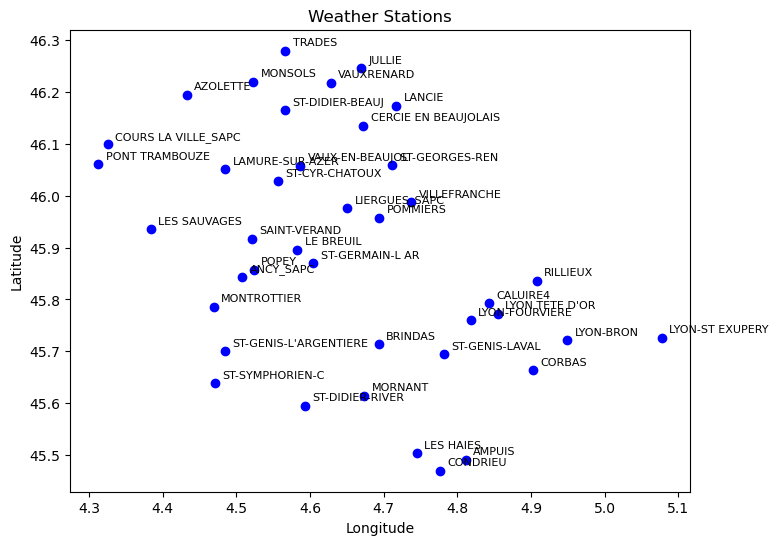

In [13]:
import matplotlib.pyplot as plt

# Remove duplicates to keep only one row per station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

plt.figure(figsize=(8,6))
plt.scatter(stations['LON'], stations['LAT'], color='blue')

# Add station names
for i, row in stations.iterrows():
    plt.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['NOM_USUEL'], fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Stations")
plt.show()





In [14]:
# Example: coordinates of Lyon center (from previous cell)
center = LYON_CENTER

# Keep one row per station
stations = df_meteo[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates()

# Haversine function to compute distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# Compute distance from each station to Lyon center
stations['distance_to_lyon_km'] = stations.apply(
    lambda row: haversine(row['LAT'], row['LON'], center[0], center[1]),
    axis=1
)

# Sort by distance
stations = stations.sort_values('distance_to_lyon_km')

# Show the 5 closest stations
print(stations[['NOM_USUEL', 'LAT', 'LON', 'distance_to_lyon_km']].head())


              NOM_USUEL        LAT       LON  distance_to_lyon_km
507643   LYON-FOURVIERE  45.759667  4.818167             1.441536
470489   LYON TETE D'OR  45.772833  4.855167             1.801364
179616         CALUIRE4  45.792833  4.843500             3.258542
817072   ST-GENIS-LAVAL  45.694667  4.782333             8.754554
1226989        RILLIEUX  45.835500  4.907833             9.717916


In [15]:
# List of wind columns (and precipitation)
vent_cols = ['FFM','FF2M','FXI','FXI2','FXI3S',"RR"]

# Check availability per station
vent_dispo = df_meteo.groupby('NOM_USUEL')[vent_cols].apply(lambda x: x.notna().sum())

# Display stations and the number of available values, sorted by FFM descending
print(vent_dispo.sort_values(by='FFM', ascending=False))


                       FFM  FF2M  FXI  FXI2  FXI3S   RR
NOM_USUEL                                              
ST-GEORGES-REN         843     0  843     0    516  843
LYON-ST EXUPERY        843     0  842     0    724  843
LYON-BRON              842     0  841     0    836  843
VAUXRENARD             838     0  838     0    486  843
LES SAUVAGES           818     0  821     0    490  843
BRINDAS                817     0  818     0    492  843
ANCY_SAPC                0     0    0     0      0  843
AMPUIS                   0     0    0     0      0  700
CORBAS                   0     0    0     0      0  365
CONDRIEU                 0     0    0     0      0  731
CERCIE EN BEAUJOLAIS     0     0    0     0      0  731
CALUIRE4                 0     0    0     0      0  700
AZOLETTE                 0     0    0     0      0  304
LE BREUIL                0     0    0     0      0  843
LANCIE                   0     0    0     0      0  700
COURS LA VILLE_SAPC      0     0    0     0     

We keep the meteo information of the station Lyon - Bron because it is the closest station from the center of Lyon that measures, the temperature the wind and the precipitation. 

In [16]:
# Filter on the station "LYON-BRON"
meteo_bron = df_meteo[df_meteo['NOM_USUEL'] == "LYON-BRON"].copy()

# Verify the result 
print(meteo_bron[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates())
print(meteo_bron.head())


        NOM_USUEL        LAT       LON
109675  LYON-BRON  45.721333  4.949167
        NUM_POSTE  NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
109675   69029001  LYON-BRON  45.721333  4.949167   202  20190101  0.0  1.0   
109676   69029001  LYON-BRON  45.721333  4.949167   202  20190102  0.0  1.0   
109677   69029001  LYON-BRON  45.721333  4.949167   202  20190103  0.0  1.0   
109678   69029001  LYON-BRON  45.721333  4.949167   202  20190104  0.0  1.0   
109679   69029001  LYON-BRON  45.721333  4.949167   202  20190105  0.0  1.0   

         TN  QTN  ...  FXI3S  QFXI3S  DXI3S  QDXI3S   HXI3S  QHXI3S  DRR  \
109675  6.5  1.0  ...    8.6     1.0    NaN     NaN  1738.0     9.0  0.0   
109676  4.0  1.0  ...   14.3     1.0    NaN     NaN  1410.0     9.0  0.0   
109677 -0.1  1.0  ...   12.6     1.0    NaN     NaN  1425.0     9.0  0.0   
109678 -0.2  1.0  ...   10.6     1.0    NaN     NaN  1319.0     9.0  0.0   
109679  1.2  1.0  ...   10.9     1.0    NaN     NaN   117.0     9.0

###  <u> **4 - Converting the weather data into usable data for modelling** </u>


In [17]:
# Create average temperature if TM is not reliable
meteo_bron['T_moy'] = meteo_bron[['TN','TX']].mean(axis=1)

# Convert wind (mean wind FFM) to km/h
meteo_bron['vent_kmh'] = meteo_bron['FFM'] * 3.6

# Create a daily aggregated DataFrame
meteo_jour = meteo_bron.groupby('AAAAMMJJ').agg({
    'T_moy': 'mean',        # daily average temperature
    'RR': 'sum',            # total daily precipitation
    'vent_kmh': 'mean'      # daily average wind speed (km/h)
}).reset_index()

# Show the first rows
display(meteo_jour.head())
meteo_jour.shape


AAAAMMJJ  T_moy   RR  vent_kmh
0  20190101   6.90  0.0     13.32
1  20190102   5.45  0.0     21.96
2  20190103   2.45  0.0     20.52
3  20190104   2.75  0.0     18.00
4  20190105   2.75  0.0     19.08

(843, 4)

In [18]:
#We create the temperature categories

conditions_temp = [
    (meteo_jour["T_moy"] < 0), 
    (meteo_jour["T_moy"] >= 0) & (meteo_jour["T_moy"] < 10),
    (meteo_jour["T_moy"] >= 10) & (meteo_jour["T_moy"] < 20),
    (meteo_jour["T_moy"] >= 20)
]
categories_temp = ["cold", "cool", "warm", "very_warm"]
meteo_jour["temp_category"] = np.select(conditions_temp, categories_temp, default="unknown")

#We create the rainfall categories

conditions_RR = [
    (meteo_jour["RR"] == 0),
    (meteo_jour["RR"] > 0) & (meteo_jour["RR"] <= 2),
    (meteo_jour["RR"] > 2) & (meteo_jour["RR"] <= 10),
    (meteo_jour["RR"] > 10)
]

categories_RR = ["none", "light", "moderate", "heavy"]

meteo_jour["rain_category"] = np.select(conditions_RR, categories_RR, default="none")

#We create the wind categories  

conditions_wind = [
    (meteo_jour["vent_kmh"] < 10),
    (meteo_jour["vent_kmh"] >= 10) & (meteo_jour["vent_kmh"] < 20),
    (meteo_jour["vent_kmh"] >= 20) & (meteo_jour["vent_kmh"] < 40),
    (meteo_jour["vent_kmh"] >= 40)
]   
categories_wind = ["calm", "light", "windy", "stormy"]
meteo_jour["wind_category"] = np.select(conditions_wind, categories_wind, default="unknown")

meteo_jour

AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category
0    20190101   6.90  0.0     13.32          cool          none         light
1    20190102   5.45  0.0     21.96          cool          none         windy
2    20190103   2.45  0.0     20.52          cool          none         windy
3    20190104   2.75  0.0     18.00          cool          none         light
4    20190105   2.75  0.0     19.08          cool          none         light
..        ...    ...  ...       ...           ...           ...           ...
838  20210418   9.25  0.0     15.48          cool          none         light
839  20210419  10.25  0.0     10.44          warm          none         light
840  20210420  11.15  0.2      7.20          warm         light          calm
841  20210421  12.80  0.2      7.92          warm         light          calm
842  20210422  13.85  0.0      9.00          warm          none          calm

[843 rows x 7 columns]

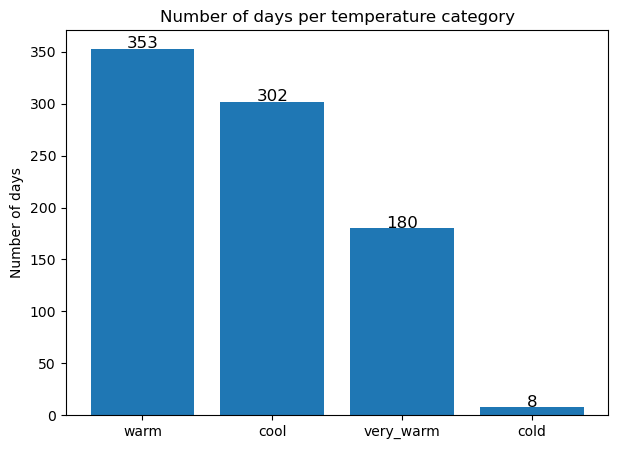

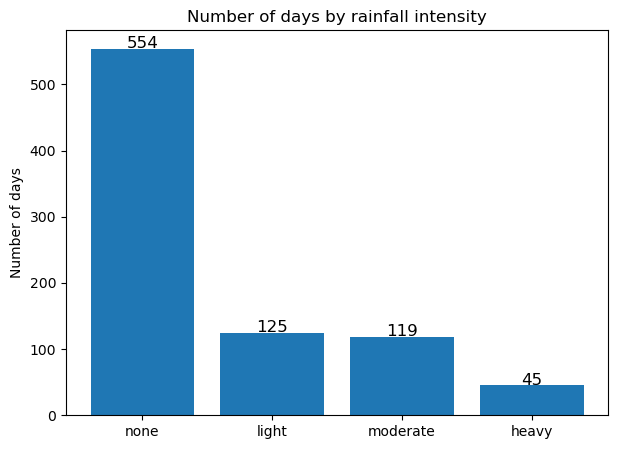

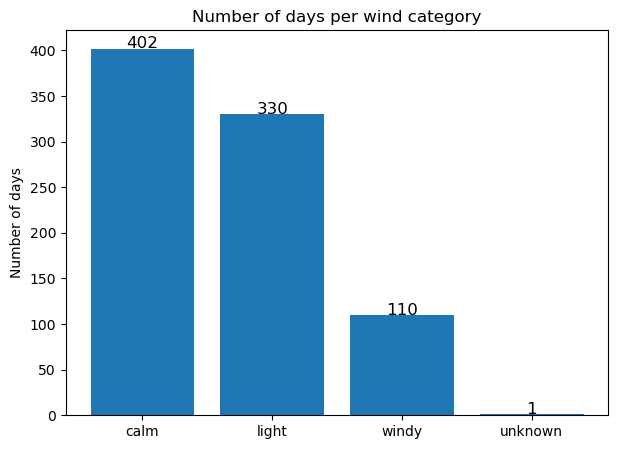

In [19]:

# Plot for temperature categories
plt.figure(figsize=(7,5))
temp_counts = meteo_jour["temp_category"].value_counts()

plt.bar(temp_counts.index, temp_counts.values)
plt.ylabel("Number of days")
plt.title("Number of days per temperature category")

for i, v in enumerate(temp_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for rain categories
plt.figure(figsize=(7,5))
rain_counts = meteo_jour["rain_category"].value_counts()

plt.bar(rain_counts.index, rain_counts.values)
plt.ylabel("Number of days")
plt.title("Number of days by rainfall intensity")

for i, v in enumerate(rain_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for wind categories
plt.figure(figsize=(7,5))
wind_counts = meteo_jour["wind_category"].value_counts()

plt.bar(wind_counts.index, wind_counts.values)
plt.ylabel("Number of days")
plt.title("Number of days per wind category")

for i, v in enumerate(wind_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()




Note : I don't know why there is an unkwon category 

In [20]:
# Convert to string
meteo_jour["AAAAMMJJ"] = meteo_jour["AAAAMMJJ"].astype(int).astype(str)

# Convert to datetime
meteo_jour["datetime_day"] = pd.to_datetime(meteo_jour["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify
print(meteo_jour)


     AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category  \
0    20190101   6.90  0.0     13.32          cool          none         light   
1    20190102   5.45  0.0     21.96          cool          none         windy   
2    20190103   2.45  0.0     20.52          cool          none         windy   
3    20190104   2.75  0.0     18.00          cool          none         light   
4    20190105   2.75  0.0     19.08          cool          none         light   
..        ...    ...  ...       ...           ...           ...           ...   
838  20210418   9.25  0.0     15.48          cool          none         light   
839  20210419  10.25  0.0     10.44          warm          none         light   
840  20210420  11.15  0.2      7.20          warm         light          calm   
841  20210421  12.80  0.2      7.92          warm         light          calm   
842  20210422  13.85  0.0      9.00          warm          none          calm   

    datetime_day  
0     20

In [21]:
df_lyon["datetime_day"] = pd.to_datetime(df_lyon["datetime_1h"], format="%Y%m%d").dt.date
df_lyon.head()

id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  day  month  travel_time     distance      speed  \
0 2019-04-01 00:00:00+02:00    0      4         28.0  4659.845582   9.985383   
1 2019-04-01 00:00:00+02:00    0      4          7.0  1629.727220  13.969090   
2 2019-04-01 00:00:00+02:00    0      4          7.0  1610.518885  13.804448   
3 2019-04-01 00:00:00+02:00    0      4         14.0  3446.325685  14.769967   
4 2019-04-01 00:00:00+02:00    0      4          4.0   807.072642  12.106090   

  datetime_day  
0   2019-04-01  
1   2019-04-01  
2   2019-04-01  
3   2019-04-01  
4   2019-04-01

In [22]:
df_meteo = df_lyon.merge(meteo_jour, on="datetime_day", how="left")
df_meteo

id_exit_station                         exit_station  \
0                   8058             8058 - LONGEFER / KRUGER   
1                  10103        10103 - DOUA / RUE DES SPORTS   
2                   3003          3003 - PART-DIEU / DERUELLE   
3                   6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4                   7033      7033 - SAINT-LUC / SAINT-JOSEPH   
...                  ...                                  ...   
1930569             7024             7024 - BANCEL / CHEVREUL   
1930570            10087                      10087 - BARATIN   
1930571             2026         2026 - RÉPUBLIQUE / PAUFIQUE   
1930572             3084                        3084 - DESAIX   
1930573             7061           7061 - JAURES / UNIVERSITE   

                        date_exit  id_return_station  \
0       2019-04-01 00:00:00+02:00             1022.0   
1       2019-04-01 00:00:00+02:00             6042.0   
2       2019-04-01 00:00:00+02:00             2016.0   
3       2019-04-01 00:00:00+02:00             3005.0   
4       2019-04-01 00:01:00+02:00             7053.0   
...                           ...                ...   
1930569 2019-06-30 23:59:00+02:00             2012.0   
1930570 2019-06-30 23:59:00+02:00            10074.0   
1930571 2019-06-30 23:59:00+02:00            10011.0   
1930572 2019-06-30 23:59:00+02:00             7023.0   
1930573 2019-06-30 23:59:00+02:00             8025.0   

                                           return_station  \
0                                    1022 - PLACE TOLOZAN   
1        6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE   
2                                     2016 - PLACE REGAUD   
3                                  3005 - SAXE / GAMBETTA   
4                             7053 - JAURÈS / THIBAUDIÈRE   
...                                                   ...   
1930569                                  2012 - GAILLETON   
1930570                        10074 - ZOLA / PASSAGE REY   
1930571                               10011 - GRATTE-CIEL   
1930572                7023 - BERTHELOT / ROUTE DE VIENNE   
1930573                            8025 - DUMONT / JOUVET   

                      date_return               datetime_1h  day  month  \
0       2019-04-01 00:28:00+02:00 2019-04-01 00:00:00+02:00    0      4   
1       2019-04-01 00:07:00+02:00 2019-04-01 00:00:00+02:00    0      4   
2       2019-04-01 00:07:00+02:00 2019-04-01 00:00:00+02:00    0      4   
3       2019-04-01 00:14:00+02:00 2019-04-01 00:00:00+02:00    0      4   
4       2019-04-01 00:05:00+02:00 2019-04-01 00:00:00+02:00    0      4   
...                           ...                       ...  ...    ...   
1930569 2019-07-01 00:05:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1930570 2019-07-01 00:23:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1930571 2019-07-01 00:14:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1930572 2019-07-01 00:09:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1930573 2019-07-01 00:19:00+02:00 2019-06-30 23:00:00+02:00    6      6   

         travel_time     distance      speed datetime_day  AAAAMMJJ  T_moy  \
0               28.0  4659.845582   9.985383   2019-04-01  20190401  13.35   
1                7.0  1629.727220  13.969090   2019-04-01  20190401  13.35   
2                7.0  1610.518885  13.804448   2019-04-01  20190401  13.35   
3               14.0  3446.325685  14.769967   2019-04-01  20190401  13.35   
4                4.0   807.072642  12.106090   2019-04-01  20190401  13.35   
...              ...          ...        ...          ...       ...    ...   
1930569          6.0   780.698976   7.806990   2019-06-30  20190630  30.85   
1930570         24.0  2143.386270   5.358466   2019-06-30  20190630  30.85   
1930571         15.0  3669.217483  14.676870   2019-06-30  20190630  30.85   
1930572         10.0  1669.803364  10.018820   2019-06-30  20190630  30.85   
1930573         20.0  1444.637130   4.333911   2019-06-30  2019

## <u> **II/ Regression modelling** </u>
###  <u> **1 - Simple linear regression** </u>
#### a/ Model 0 definition

In [23]:
# STEP 1 - EXTRACTING THE RELEVANT COLUMNS
y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - SPLITTING THE DATA INTO TRAINING AND TEST SETS
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - CREATING AND TRAINING THE MODEL
model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

# Displaying the intercept with minutes (rounded to the lower value) and seconds and the average speed of the biker in km/h
print("The model's intercept is: ", int(model.intercept_), "minutes and", int((model.intercept_%1)*60), "seconds")
print("The estimated biker goes at: ", int(360/(model.coef_[0]*60))/100, "km/h in average")

# STEP 4 - EVALUATING THE MODEL
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

The model's intercept is:  1 minutes and 19 seconds
The estimated biker goes at:  10.31 km/h in average


R²      0.658725
MSE    18.788255
MAE     2.751422
dtype: float64

#### b/ Model 0 estimation

In [24]:
estimated_time_15km = model.intercept_ + 15000*model.coef_[0]
print("Estimated time for a 5km travel on bike: ", round(estimated_time_15km), "minutes")

Estimated time for a 5km travel on bike:  89 minutes


In [25]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 5min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

###  <u> **2 - Multiple linear regression** </u>
#### a/ Model 1 - Adding the day of the week parameter

In [26]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day']].copy()
# Converting day to integer type
df_model1['day'] = df_model1['day'].astype(int)
df_model1.sample(5)

distance  travel_time               datetime_1h  day
1210880  4288.676989         23.0 2019-05-21 07:00:00+02:00    1
457637   2342.863184         11.0 2019-04-18 15:00:00+02:00    3
454892   4534.403697         36.0 2019-04-18 13:00:00+02:00    3
773158    895.407946          6.0 2019-05-02 12:00:00+02:00    3
1387353   502.852294          3.0 2019-05-27 13:00:00+02:00    0

In [27]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies_day = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies_day.sample(5)

distance  travel_time               datetime_1h  day_1  day_2  \
1815059   459.169401          3.0 2019-06-15 18:00:00+02:00      0      0   
2125488  1512.414887         10.0 2019-06-29 17:00:00+02:00      0      0   
105501   1349.415930          5.0 2019-04-05 00:00:00+02:00      0      0   
1329564  2493.016661         14.0 2019-05-24 22:00:00+02:00      0      0   
1175898  3038.706874         20.0 2019-05-19 16:00:00+02:00      0      0   

         day_3  day_4  day_5  day_6  
1815059      0      0      1      0  
2125488      0      0      1      0  
105501       0      1      0      0  
1329564      0      1      0      0  
1175898      0      0      0      1

Coefficient
day_5         1.280329
day_6         1.104139
day_2         0.372667
day_4         0.314074
day_3         0.122918
day_1         0.036479
distance      0.005801
intercept     0.971663

R²      0.661900
MSE    18.613482
MAE     2.748773
dtype: float64

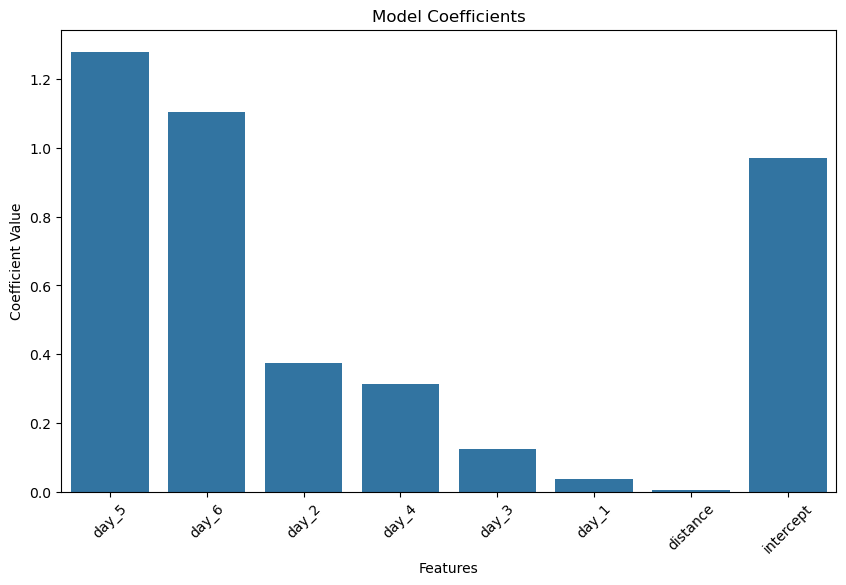

In [28]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies_day['travel_time']
X = df_model1_dummies_day.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Model 1 - Adding the time of day parameter

In [29]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

distance  travel_time               datetime_1h  day_1  day_2  \
1913527  1071.361703          6.0 2019-06-20 05:00:00+02:00      0      0   
81030     781.216179          5.0 2019-04-04 07:00:00+02:00      0      0   
1529773  4171.199381         24.0 2019-06-02 03:00:00+02:00      0      0   
1250082  2456.673353         15.0 2019-05-22 14:00:00+02:00      0      1   
791560   3492.213752         17.0 2019-05-03 01:00:00+02:00      0      0   

         day_3  day_4  day_5  day_6  hour_1  ...  hour_14  hour_15  hour_16  \
1913527      1      0      0      0       0  ...        0        0        0   
81030        1      0      0      0       0  ...        0        0        0   
1529773      0      0      0      1       0  ...        0        0        0   
1250082      0      0      0      0       0  ...        1        0        0   
791560       0      1      0      0       1  ...        0        0        0   

         hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  
1913527        0        0        0        0        0        0        0  
81030          0        0        0        0        0        0        0  
1529773        0        0        0        0        0        0        0  
1250082        0        0        0        0        0        0        0  
791560         0        0        0        0        0        0        0  

[5 rows x 32 columns]

Coefficient
day_5         1.081295
day_6         0.878439
hour_15       0.700195
hour_16       0.562581
hour_3        0.549247
hour_2        0.532429
hour_1        0.427049
hour_14       0.386314
day_2         0.354920
day_4         0.297086
hour_17       0.221634
hour_18       0.132297
day_3         0.119381
day_1         0.055577
hour_4        0.007274
distance      0.005800
hour_19      -0.001651
hour_11      -0.050929
hour_20      -0.174388
hour_22      -0.211752
hour_12      -0.271297
hour_21      -0.276673
hour_13      -0.279449
hour_10      -0.284737
hour_23      -0.304124
hour_9       -1.033471
hour_8       -1.198626
hour_5       -1.396855
hour_7       -1.670295
hour_6       -2.037892
intercept     1.200918

R²      0.666599
MSE    18.354778
MAE     2.734687
dtype: float64

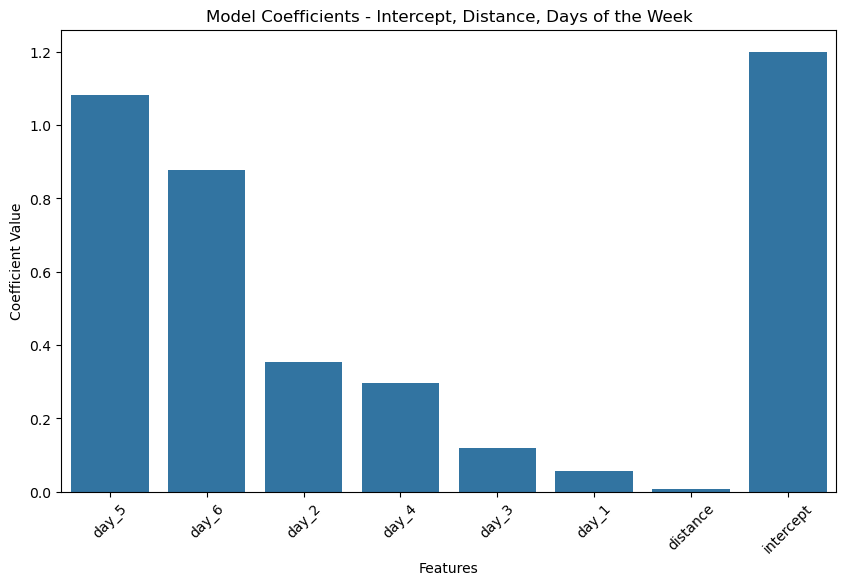

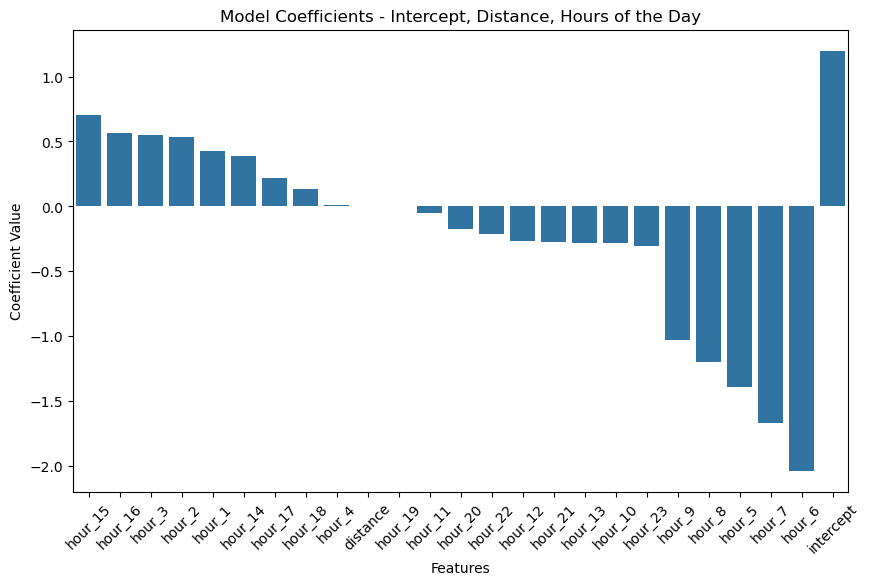

C:\Users\ndamb\AppData\Local\Temp\ipykernel_5448\1607004228.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)


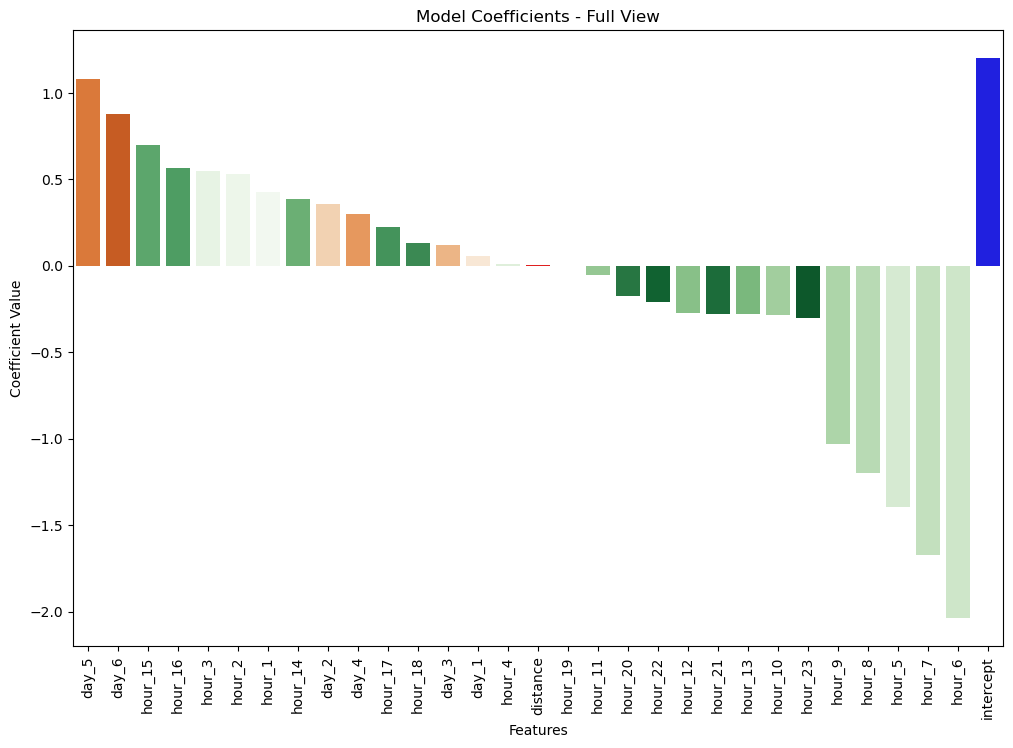

In [30]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('red')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

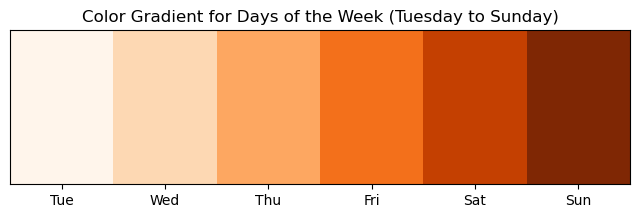

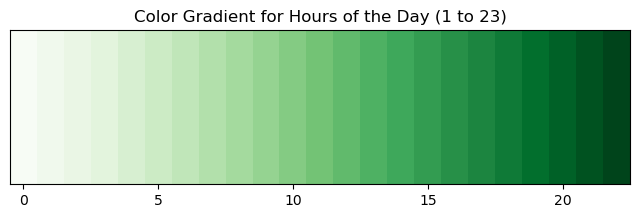

In [31]:
# Plotting a legend for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Oranges')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()

## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()

In [32]:
# Estimating 15km travel times with different hours of the day and days of the week with model1_day_hour
TT_15km_model1_day_hour = {}
for day in range(7):
    for hour in range(24):
        # Creating a dataframe with the distance, day and hour
        data = {'distance': [15000]}
        for d in range(1, 7):
            data[f'day_{d}'] = [1 if d == day else 0]
        for h in range(1, 24):
            data[f'hour_{h}'] = [1 if h == hour else 0]
        X_temp = pd.DataFrame(data)
        # Predicting the travel time
        TT_15km_model1_day_hour[(day, hour)] = model1_day_hour.predict(X_temp)[0]

# Displaying the estimated travel times for a 15km trip in a dataframe
df_TT_15km_model1_day_hour = pd.DataFrame.from_dict(TT_15km_model1_day_hour, orient='index', columns=['Estimated Travel Time (minutes)'])
df_TT_15km_model1_day_hour.index = pd.MultiIndex.from_tuples(df_TT_15km_model1_day_hour.index, names=['Day of the Week', 'Hour of the Day'])
df_TT_15km_model1_day_hour = df_TT_15km_model1_day_hour.sort_index()
df_TT_15km_model1_day_hour.sample(10)

Estimated Travel Time (minutes)
Day of the Week Hour of the Day                                 
6               11                                     89.033788
0               16                                     88.768860
5               14                                     89.673887
                22                                     89.075821
2               22                                     88.349446
5               0                                      89.287573
4               23                                     88.199241
0               8                                      87.007652
                7                                      86.535983
5               23                                     88.983449

In [33]:
from functions.estimator import MLR_model_estimator

# Example
test_distance = 15000  # in meters
test_travel_time = None  # unknown, to be predicted
test_datetime_1h = '2020-01-07 08:15:00'  # example datetime
test_day = 1  # Tuesday
test_month = 1  # January

sample_list = [test_distance, test_travel_time, test_datetime_1h, test_day, test_month]
pred = MLR_model_estimator(
    model=model1_day_hour,
    features=sample_list,
    feature_names=['distance','travel_time','datetime_1h','day','month'],
    model_feature_names=X.columns,   # X is the training DataFrame's columns used to fit the model
    show_steps=True
)
print(f"The predicted travel time for a {test_distance/1000} km trip is: {round(pred)} minutes")

[STEP] Starting estimation
[STEP] Extracted base features: {'distance': 15000, 'day': 1, 'datetime_1h': '2020-01-07 08:15:00', 'month': 1}
[STEP] distance = 15000.0
[STEP] Using provided day = 1
[STEP] Derived hour from datetime_1h = 8
[STEP] Using provided month = 1
[STEP] Using provided model_feature_names
[INFO] model will expect 30 features: ['distance', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
[STEP] Built input vector (first 10 values shown): [1.5e+04 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]
[STEP] Model intercept = 1.200917521878882
[STEP] Model has 30 coefficients; input vector length = 30
[RESULT] Predicted travel time = 87.06322969889128
The predicted travel time for a 15.0 km trip is: 87 mi

#### c/ Model 2 - Adding the temperature, the rain, and the wind

In [34]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2 = df_meteo[['distance', 'travel_time', 'datetime_1h', 'day', 'temp_category', 'rain_category', 'wind_category']].copy()
df_model2['hour'] = df_model2['datetime_1h'].dt.hour
# Filtering out the rows with 'unknown' categories
df_model2 = df_model2[
    (df_model2['temp_category'] != 'unknown') &
    (df_model2['wind_category'] != 'unknown')
].copy()
# Converting day and hour to integer type
df_model2['day'] = df_model2['day'].astype(int)
df_model2['hour'] = df_model2['hour'].astype(int)
df_model2.sample(5)

distance  travel_time               datetime_1h  day  \
1627692  5096.991098         37.0 2019-06-14 21:00:00+02:00    4   
395862   1892.787746         12.0 2019-04-17 17:00:00+02:00    2   
636331   2127.849121         11.0 2019-04-30 09:00:00+02:00    1   
1052621   768.517373          9.0 2019-05-18 16:00:00+02:00    5   
1858404  3005.991755         19.0 2019-06-26 18:00:00+02:00    2   

        temp_category rain_category wind_category  hour  
1627692          warm         heavy          calm    21  
395862           warm          none         light    17  
636331           warm          none         light     9  
1052621          warm      moderate          calm    16  
1858404     very_warm          none         light    18

In [35]:
df_model2_dummies_hours_days = pd.get_dummies(df_model2, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model2_dummies = pd.get_dummies(df_model2_dummies_hours_days, columns=['temp_category', 'rain_category', 'wind_category'], drop_first=True, dtype="int")
df_model2_dummies.sample(5)

distance  travel_time               datetime_1h  day_1  day_2  \
1257224   638.012374          5.0 2019-05-27 12:00:00+02:00      0      0   
130567   5096.605099         35.0 2019-04-06 09:00:00+02:00      0      0   
995837   1296.065968         10.0 2019-05-16 08:00:00+02:00      0      0   
453292   1346.228757         11.0 2019-04-19 21:00:00+02:00      0      0   
193729   1842.485198         12.0 2019-04-09 08:00:00+02:00      1      0   

         day_3  day_4  day_5  day_6  hour_1  ...  hour_21  hour_22  hour_23  \
1257224      0      0      0      0       0  ...        0        0        0   
130567       0      0      1      0       0  ...        0        0        0   
995837       1      0      0      0       0  ...        0        0        0   
453292       0      1      0      0       0  ...        1        0        0   
193729       0      0      0      0       0  ...        0        0        0   

         temp_category_very_warm  temp_category_warm  rain_category_light  \
1257224                        0                   1                    0   
130567                         0                   1                    0   
995837                         0                   1                    0   
453292                         0                   1                    0   
193729                         0                   1                    0   

         rain_category_moderate  rain_category_none  wind_category_light  \
1257224                       1                   0                    1   
130567                        0                   1                    1   
995837                        0                   1                    0   
453292                        0                   1                    0   
193729                        0                   1                    0   

         wind_category_windy  
1257224                    0  
130567                     0  
995837                     0  
453292                     0  
193729                     0  

[5 rows x 39 columns]

In [36]:
df_model2_dummies.columns

Index(['distance', 'travel_time', 'datetime_1h', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'temp_category_very_warm', 'temp_category_warm', 'rain_category_light',
       'rain_category_moderate', 'rain_category_none', 'wind_category_light',
       'wind_category_windy'],
      dtype='object')

Coefficient
day_5                       1.099857
day_6                       0.990092
hour_15                     0.684543
rain_category_none          0.582253
hour_3                      0.567951
hour_16                     0.543363
hour_2                      0.535103
day_2                       0.473957
temp_category_very_warm     0.444560
hour_1                      0.425889
hour_14                     0.368021
day_4                       0.275716
rain_category_light         0.274521
hour_17                     0.212465
temp_category_warm          0.180743
day_3                       0.166568
day_1                       0.144355
hour_18                     0.118965
rain_category_moderate      0.057214
distance                    0.005789
hour_4                      0.005394
hour_19                    -0.026616
hour_11                    -0.060807
hour_20                    -0.205620
hour_22                    -0.246391
wind_category_light        -0.256874
hour_12                    -0.284995
hour_13                    -0.294293
hour_10                    -0.299335
hour_21                    -0.310988
hour_23                    -0.338977
wind_category_windy        -0.451732
hour_9                     -1.037554
hour_8                     -1.188414
hour_5                     -1.404207
hour_7                     -1.658298
hour_6                     -2.031997
intercept                   0.769600

R²      0.666520
MSE    18.359107
MAE     2.796976
dtype: float64

C:\Users\ndamb\AppData\Local\Temp\ipykernel_5448\1299345761.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)


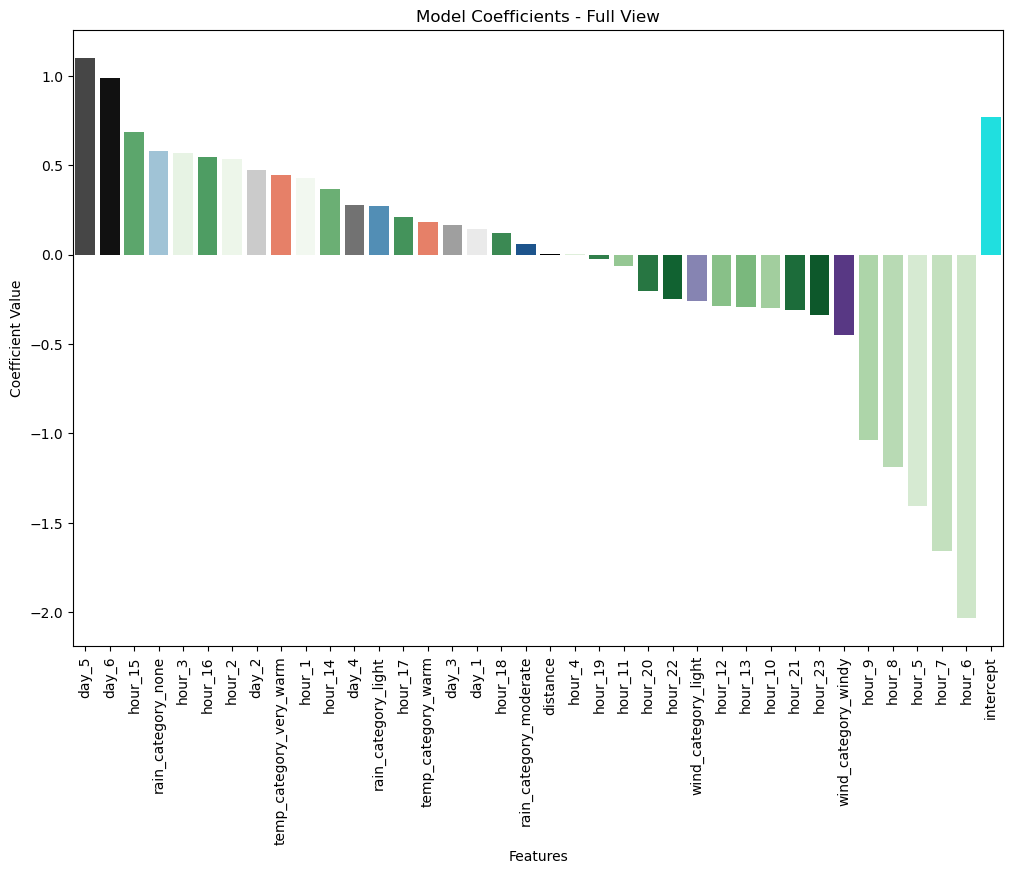

In [56]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model2_dummies['travel_time']
X = df_model2_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 2
model2 = LinearRegression()
model2.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2, X)
display(df_model2_coeffs)

## Displaying the model 1's validation serie
y_pred_model2 = model2.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)
display(s_model2_validation)

## Plotting a bar plot of the model's coefficients with separate colors for the different types of features
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model2_coeffs.index:
    # Intercept is in cyan and is an interger (in minutes)
    if idx == 'intercept':
        colors.append('cyan')
    # Distance is in black and is an integer (in min/m)
    elif idx == 'distance':
        colors.append('black')
    # The days are in grey
    elif idx.startswith('day_'):
        colors.append(plt.cm.Greys(int(idx.split('_')[1]) * 40))
    # The hours are in green
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    # The temperature is in red 
    elif idx.startswith('temp_category_'):
        colors.append(plt.cm.Reds((['cold', 'cool', 'warm', 'very_warm'].index(idx.split('_')[-1])) * 60))
    # The rain is in deep blue
    elif idx.startswith('rain_category_'):
        colors.append(plt.cm.Blues((['none', 'light', 'moderate', 'heavy'].index(idx.split('_')[-1])) * 60 + 100))
    # The wind is in purple and is composed of categories (strings)
    elif idx.startswith('wind_category_'):
        colors.append(plt.cm.Purples((['calm', 'light', 'windy', 'stormy'].index(idx.split('_')[-1])) * 60 + 100))
    else:
        colors.append('gray')
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

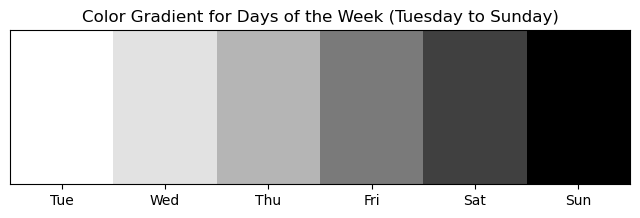

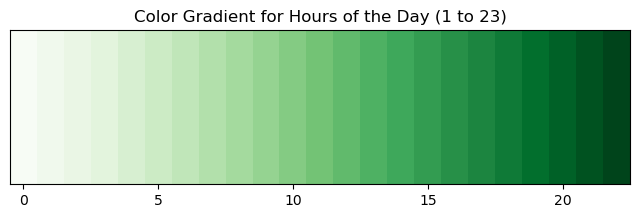

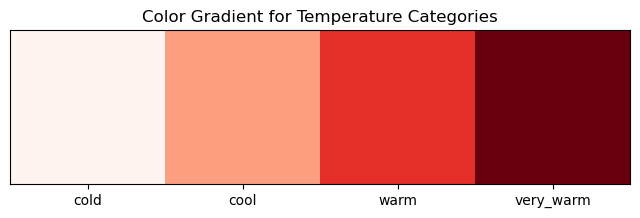

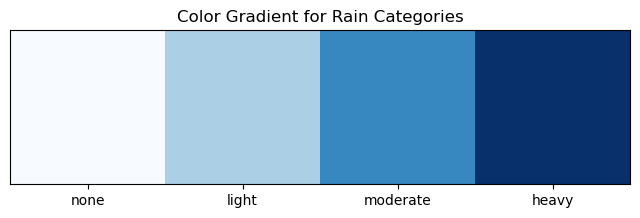

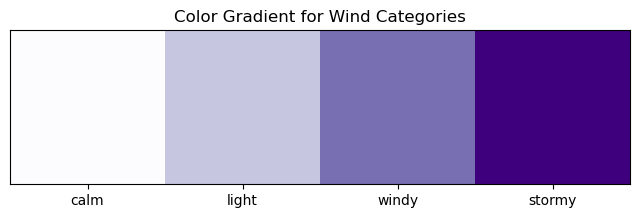

In [ ]:
# Plotting the color legends for the previous code that plotted the complete bar graph
## Fixed color for Days of the Week (Tuesday to Sunday)
plt.figure(figsize=(8, 2))
fixed_days = np.ones((1, 6))
plt.imshow(fixed_days, aspect='auto', cmap='Greys', vmin=0, vmax=1)
plt.title('Color for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()
## Fixed color for Hours of the Day (1 to 23)
plt.figure(figsize=(8, 2))
fixed_hours = np.ones((1, 23))
plt.imshow(fixed_hours, aspect='auto', cmap='Greens', vmin=0, vmax=1)
plt.title('Color for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()
## Fixed color for temperature categories
plt.figure(figsize=(8, 2))
categories_temp = ["cold", "cool", "warm", "very_warm"]
fixed_temp = np.ones((1, len(categories_temp)))
plt.imshow(fixed_temp, aspect='auto', cmap='Reds', vmin=0, vmax=1)
plt.title('Color for Temperature Categories')
# Changing the legend to show the temperature categories
plt.xticks(ticks=np.arange(len(categories_temp)), labels=categories_temp)
plt.yticks([])
plt.show()
## Fixed color for rain categories
plt.figure(figsize=(8, 2))
categories_RR = ["none", "light", "moderate", "heavy"]
fixed_rain = np.ones((1, len(categories_RR)))
plt.imshow(fixed_rain, aspect='auto', cmap='Blues', vmin=0, vmax=1)
plt.title('Color for Rain Categories')
# Changing the legend to show the rain categories
plt.xticks(ticks=np.arange(len(categories_RR)), labels=categories_RR)
plt.yticks([])
plt.show()
## Fixed color for wind categories
plt.figure(figsize=(8, 2))
categories_wind = ["calm", "light", "windy", "stormy"]
fixed_wind = np.ones((1, len(categories_wind)))
plt.imshow(fixed_wind, aspect='auto', cmap='Purples', vmin=0, vmax=1)
plt.title('Color for Wind Categories')
# Changing the legend to show the wind categories
plt.xticks(ticks=np.arange(len(categories_wind)), labels=categories_wind)
plt.yticks([])
plt.show()

###  <u> **3 - More advanced modelling techniques** </u>

#### a/ Ridge Regression

[INFO] X shape: (1930574, 37), y shape: (1930574,)
[STEP] Running RidgeCV with 2-fold CV to select best alpha...
[RESULT] Best alpha found by RidgeCV: 1.0
[RESULT] Best alpha found by RidgeCV: 1.0


Ridge_Coefficient
distance           6.006646
day_1              0.050260
day_2              0.135857
day_3              0.056594
day_4              0.114850
day_5              0.343848
day_6              0.281732
hour_1             0.051313
hour_2             0.051261
hour_3             0.046353
hour_4            -0.001845
hour_5            -0.116835
hour_6            -0.220143
hour_7            -0.344836
hour_8            -0.330391
hour_9            -0.224911
hour_10           -0.064364
hour_11           -0.027042
hour_12           -0.085381
hour_13           -0.086728

[INFO] Example of Ridge vs OLS coefficients (first rows):


Ridge_Coefficient  OLS_Coefficient
distance           6.006646         0.005789
day_1              0.050260         0.144355
day_2              0.135857         0.473957
day_3              0.056594         0.166568
day_4              0.114850         0.275716
day_5              0.343848         1.099857
day_6              0.281732         0.990092
hour_1             0.051313         0.425889
hour_2             0.051261         0.535103
hour_3             0.046353         0.567951
hour_4            -0.001845         0.005394
hour_5            -0.116835        -1.404207
hour_6            -0.220143        -2.031997
hour_7            -0.344836        -1.658298
hour_8            -0.330391        -1.188414
hour_9            -0.224911        -1.037554
hour_10           -0.064364        -0.299335
hour_11           -0.027042        -0.060807
hour_12           -0.085381        -0.284995
hour_13           -0.086728        -0.294293

C:\Users\ndamb\AppData\Local\Temp\ipykernel_5448\93279902.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ridge_coeffs['Ridge_Coefficient'].values, y=df_ridge_coeffs.index, palette=colors, orient='h')


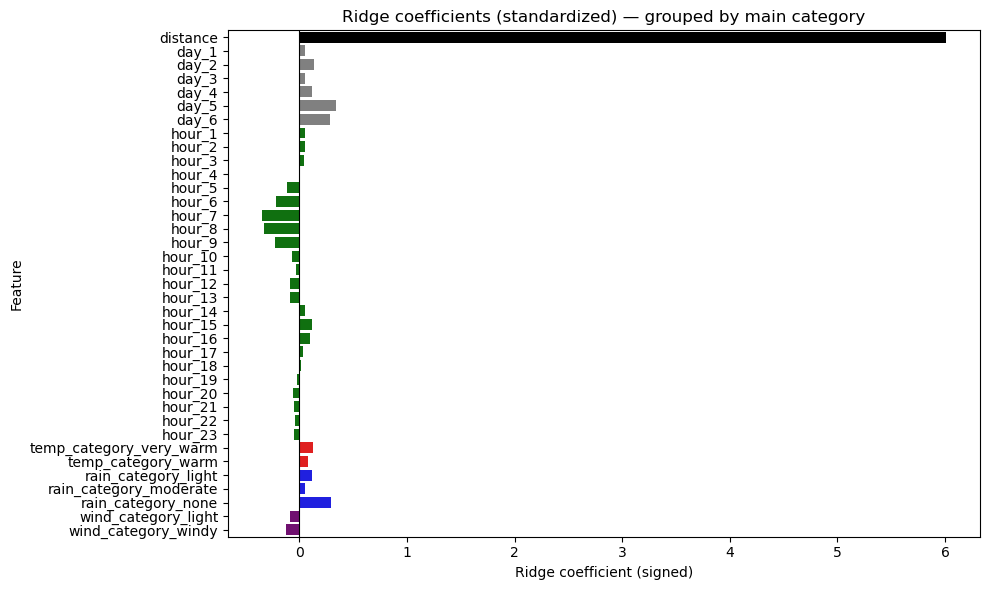

[CV] RidgeCV pipeline R² (2-fold): mean=0.6611, std=0.0008
[CV] RidgeCV pipeline MSE (2-fold): mean=18.9068, std=0.2965
[DONE] Optimized Ridge Regression analysis complete.


In [57]:
# --- Ridge Regression (standardized) workflow (optimized for speed & memory)
# Standardizes df_model2_dummies features, performs RidgeCV to select alpha,
# fits the final Ridge model and displays/plots the coefficients grouped by category.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# 1) Prepare X and y
y = df_model2_dummies['travel_time']
X = df_model2_dummies.drop(columns=['datetime_1h', 'travel_time'])

print(f"[INFO] X shape: {X.shape}, y shape: {y.shape}")

# 2) Define a pipeline with StandardScaler and RidgeCV (use fewer alphas and 2-fold CV)
# Reduced alpha search because we expect best alpha ~50
alphas = np.logspace(0, 2, 20)  # from 10 to 100, 20 values (includes ~50)
ridgecv_pipe = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=2, scoring='neg_mean_squared_error')
)

print("[STEP] Running RidgeCV with 2-fold CV to select best alpha...")
ridgecv_pipe.fit(X, y)

# retrieve the trained RidgeCV estimator inside the pipeline
ridgecv = ridgecv_pipe.named_steps['ridgecv']
best_alpha = ridgecv.alpha_
print(f"[RESULT] Best alpha found by RidgeCV: {best_alpha}")

# 3) Extract coefficients (standardized scale) and build a lightweight DataFrame
coeffs = pd.Series(ridgecv.coef_, index=X.columns, name='Ridge_Coefficient')
df_ridge_coeffs = coeffs.to_frame()
# (deleted creation of abs_coef to save memory as requested)

display(df_ridge_coeffs.head(20))

# 4) OLS coefficients: prefer using the already computed model2 coefficients if available
if 'df_model2_coeffs' in globals():
    try:
        ols_coeffs = pd.Series(df_model2_coeffs['Coefficient'].values, index=df_model2_coeffs.index, name='OLS_Coefficient')
        # if df_model2_coeffs contains only the features we need, reindex to X.columns
        if set(ols_coeffs.index) >= set(X.columns):
            ols_coeffs = ols_coeffs.reindex(X.columns)
        else:
            # fallback: compute OLS on standardized X
            lr = LinearRegression()
            lr.fit(StandardScaler().fit_transform(X), y)
            ols_coeffs = pd.Series(lr.coef_, index=X.columns, name='OLS_Coefficient')
    except Exception:
        lr = LinearRegression()
        lr.fit(StandardScaler().fit_transform(X), y)
        ols_coeffs = pd.Series(lr.coef_, index=X.columns, name='OLS_Coefficient')
else:
    # compute simple OLS on standardized features
    lr = LinearRegression()
    lr.fit(StandardScaler().fit_transform(X), y)
    ols_coeffs = pd.Series(lr.coef_, index=X.columns, name='OLS_Coefficient')

# Build compare dataframe but do not create extra large columns
df_compare = pd.concat([df_ridge_coeffs['Ridge_Coefficient'], ols_coeffs], axis=1)

print("[INFO] Example of Ridge vs OLS coefficients (first rows):")
display(df_compare.head(20))

# 5) One combined plot: uniform colors per main category and category-based sorting
# Define category ordering
category_order = [
    'intercept',
    'distance',
    'day_',
    'hour_',
    'temp_category_',
    'rain_category_',
    'wind_category_'
]

col_pos = {c: i for i, c in enumerate(X.columns)}

def category_key(name):
    for i, prefix in enumerate(category_order):
        if prefix.endswith('_'):
            if name.startswith(prefix):
                return (i, col_pos.get(name, 0))
        else:
            if name == prefix:
                return (i, col_pos.get(name, 0))
    # others last
    return (len(category_order), col_pos.get(name, 0))

sorted_cols = sorted(list(X.columns), key=category_key)
# reorder df_ridge_coeffs accordingly
df_ridge_coeffs = df_ridge_coeffs.reindex(sorted_cols)

# uniform colors per main category
palette_map = {
    'intercept': 'cyan',
    'distance': 'black',
    'day_': 'gray',
    'hour_': 'green',
    'temp_category_': 'red',
    'rain_category_': 'blue',
    'wind_category_': 'purple'
}

colors = []
for name in df_ridge_coeffs.index:
    assigned = 'gray'
    for prefix, col in zip(category_order, [None]*len(category_order)):
        if prefix.endswith('_') and name.startswith(prefix):
            assigned = palette_map.get(prefix, 'gray')
            break
        elif name == prefix:
            assigned = palette_map.get(prefix, 'gray')
            break
    colors.append(assigned)

# Plot
plt.figure(figsize=(10, max(6, len(sorted_cols)*0.08)))
sns.barplot(x=df_ridge_coeffs['Ridge_Coefficient'].values, y=df_ridge_coeffs.index, palette=colors, orient='h')
plt.title('Ridge coefficients (standardized) — grouped by main category')
plt.xlabel('Ridge coefficient (signed)')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

# 6) Cross-validated metrics (2-fold)
cv_scores_r2 = cross_val_score(ridgecv_pipe, X, y, cv=2, scoring='r2')
cv_scores_mse = cross_val_score(ridgecv_pipe, X, y, cv=2, scoring='neg_mean_squared_error')
print(f"[CV] RidgeCV pipeline R² (2-fold): mean={cv_scores_r2.mean():.4f}, std={cv_scores_r2.std():.4f}")
print(f"[CV] RidgeCV pipeline MSE (2-fold): mean={-cv_scores_mse.mean():.4f}, std={cv_scores_mse.std():.4f}")

print('[DONE] Optimized Ridge Regression analysis complete.')


**Ridge Regression workflow — Notes and how to use this cell**

- Purpose: run a Ridge regression with automatic alpha selection (via cross-validation) on `df_model2_dummies`, after standardizing features. Ridge shrinks coefficients toward zero and helps reveal which features remain important when penalization is applied.

- Main steps implemented in the code above:
  - Build `X` (features) and `y` (target) explicitly from `df_model2_dummies`.
  - Use a `Pipeline` with `StandardScaler()` followed by `RidgeCV(alphas=..., cv=5)` to avoid leakage during CV.
  - Fit the pipeline on the full dataset to obtain the best alpha and final coefficients.
  - Extract coefficients (they correspond to standardized features) and create a sorted DataFrame by absolute coefficient magnitude for interpretation.
  - Fit an OLS (linear regression) on standardized features for side-by-side comparison of coefficients.
  - Display top features and plot bar charts (plain and color-coded) of top Ridge coefficients.
  - Report cross-validated R² and MSE for the selected model.

- What you need to run this cell:
  - `df_model2_dummies` must exist (as produced earlier in the notebook) and contain only numeric feature columns plus the `travel_time` column and `datetime_1h`.
  - `scikit-learn`, `numpy`, `pandas`, `matplotlib`, and `seaborn` must be imported (they already are earlier in the notebook).

- How to interpret results:
  - The `best_alpha` is the regularization strength chosen by CV (higher alpha → stronger shrinkage).
  - The Ridge coefficients printed are for standardized features. Larger absolute values mean the feature has stronger influence after penalization.
  - Compare Ridge vs OLS coefficients. Features that remain large in Ridge are more robust; features that shrink a lot were likely less stable/important.

- Next steps / suggestions:
  - If you want coefficients on the original scale, multiply the standardized coefficients by (std(y) / std(x_j)) — the pipeline standardizes X; converting back requires access to scaling factors.
  - Try different scoring metrics for `RidgeCV` (e.g., `r2`) depending on what you prioritize.
  - If you're worried about correlated categorical dummies (e.g. many temp/rain/wind categories), consider grouping rare categories or using target encoding for categorical variables.

If you want, I can also:
- Add a small helper function that converts standardized Ridge coefficients back to original scale (with code to extract scaler params from the pipeline).
- Add a saved CSV listing the top features and their Ridge vs OLS coefficients for reporting.


#### b/ Decision Tree (first approach using top features)

Below is a first, simple Decision Tree built on the 15 most important features according to the Ridge coefficients (on standardized features). This helps interpret interactions and non-linear effects; use a shallow tree (small max_depth) to keep it interpretable.

[INFO] Selected top 15 features for Decision Tree:
 ['distance', 'hour_7', 'day_5', 'hour_8', 'rain_category_none', 'day_6', 'hour_9', 'hour_6', 'day_2', 'temp_category_very_warm', 'wind_category_windy', 'hour_15', 'hour_5', 'day_4', 'rain_category_light']
Decision Tree R² on test: 0.6661
Decision Tree MSE on test: 18.3812
Decision Tree R² on test: 0.6661
Decision Tree MSE on test: 18.3812


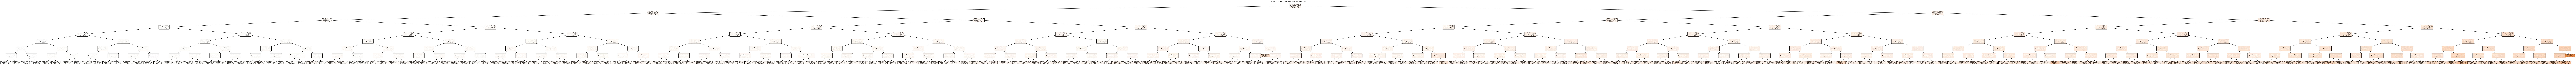

In [52]:
# Decision Tree using top 15 Ridge features
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Select top 15 features by absolute Ridge coefficient (compute abs temporarily)
abs_ridge = df_ridge_coeffs['Ridge_Coefficient'].abs()
top_n = 15
selected_features = list(abs_ridge.sort_values(ascending=False).head(top_n).index)
print(f"[INFO] Selected top {top_n} features for Decision Tree:\n", selected_features)

# Prepare data
X_dt = X[selected_features].copy()
# Use the existing my_train_test_split function
X_train_dt, X_test_dt, y_train_dt, y_test_dt = my_train_test_split(X_dt, y)

# Fit a shallow decision tree for interpretability
dt = DecisionTreeRegressor(max_depth=8, random_state=0)
dt.fit(X_train_dt, y_train_dt)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
pred_dt = dt.predict(X_test_dt)
print(f"Decision Tree R² on test: {r2_score(y_test_dt, pred_dt):.4f}")
print(f"Decision Tree MSE on test: {mean_squared_error(y_test_dt, pred_dt):.4f}")

# Plot the tree
plt.figure(figsize=(400, 10))
plot_tree(dt, feature_names=selected_features, filled=True, fontsize=8, rounded=True)
plt.title('Decision Tree (max_depth=4) on top Ridge features')
plt.show()

# Short note: decision trees can reveal interactions and thresholds; use them as exploratory tools.


#### c/ Decision Tree (using all features)

Below is a Decision Tree built on **all features** from `df_model2_dummies`. This provides a more comprehensive view of interactions and thresholds across the entire feature set.

[INFO] Decision Tree using all 37 features
Decision Tree R² on test: 0.6656
Decision Tree MSE on test: 18.4102
Decision Tree R² on test: 0.6656
Decision Tree MSE on test: 18.4102


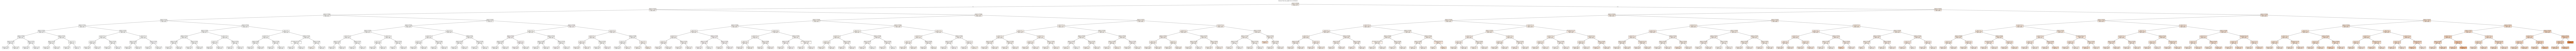

[INFO] Top 15 features by Decision Tree importance:


distance               0.987519
day_5                  0.003484
hour_8                 0.003370
hour_7                 0.002793
day_6                  0.001448
hour_16                0.000350
rain_category_none     0.000218
wind_category_light    0.000172
hour_15                0.000114
hour_9                 0.000109
hour_12                0.000086
hour_13                0.000074
day_3                  0.000073
hour_6                 0.000057
wind_category_windy    0.000037
Name: Importance, dtype: float64

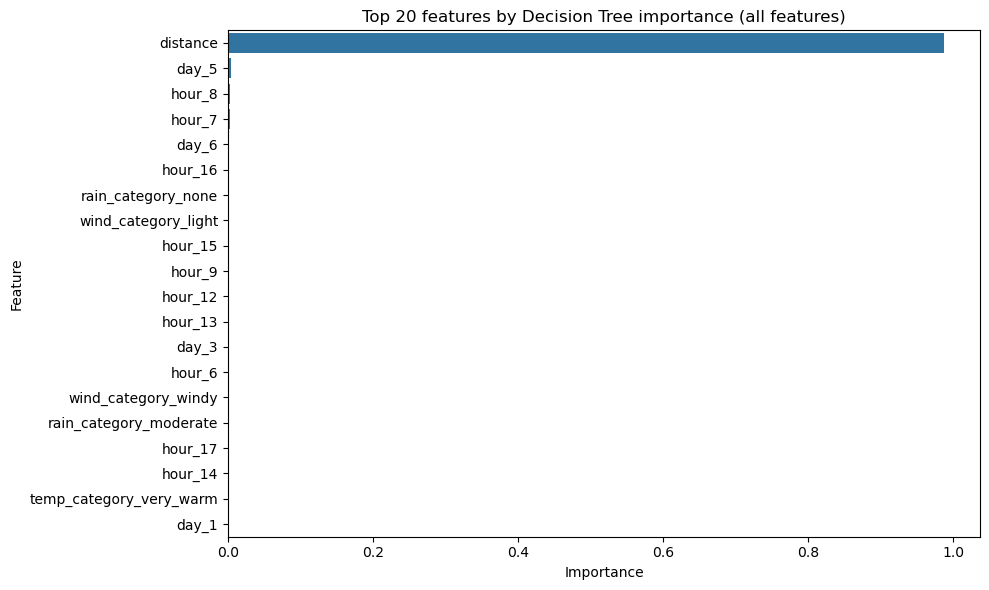

[DONE] Decision Tree (all features) analysis complete.


In [55]:
# Decision Tree using ALL features from df_model2_dummies
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Use all features
X_dt_all = X.copy()
# Use the existing my_train_test_split function
X_train_dt_all, X_test_dt_all, y_train_dt_all, y_test_dt_all = my_train_test_split(X_dt_all, y)

print(f"[INFO] Decision Tree using all {len(X.columns)} features")

# Fit a shallow decision tree for interpretability (max_depth=4 for readability)
dt_all = DecisionTreeRegressor(max_depth=8, random_state=0)
dt_all.fit(X_train_dt_all, y_train_dt_all)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
pred_dt_all = dt_all.predict(X_test_dt_all)
print(f"Decision Tree R² on test: {r2_score(y_test_dt_all, pred_dt_all):.4f}")
print(f"Decision Tree MSE on test: {mean_squared_error(y_test_dt_all, pred_dt_all):.4f}")

# Plot the tree
plt.figure(figsize=(500, 10))
plot_tree(dt_all, feature_names=list(X.columns), filled=True, fontsize=8, rounded=True)
plt.title('Decision Tree (max_depth=4) on all features')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.Series(dt_all.feature_importances_, index=X.columns, name='Importance')
feature_importance = feature_importance.sort_values(ascending=False)
print("[INFO] Top 15 features by Decision Tree importance:")
display(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(20).values, y=feature_importance.head(20).index, orient='h')
plt.title('Top 20 features by Decision Tree importance (all features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('[DONE] Decision Tree (all features) analysis complete.')
